<a href="https://colab.research.google.com/github/ccarballo50/sivira-trends-lag/blob/main/SIVIRA_TRENDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================
# CELDA 1 — SETUP
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# === RUTAS (ajusta si lo tienes en Drive) ===
SIVIRA_XLSX = "tablas_informe_SiVIRA_202551.xlsx"

GT_GRIPE_CSV = "google_trends_daily_GRIPE.csv"
GT_VRS_CSV   = "google_trends_daily_VRS.csv"
GT_COVID_CSV = "google_trends_daily_COVID.csv"

# === OUTPUTS ===
OUT_WEEKLY_MERGED = "merged_sivira_trends_weekly.csv"
OUT_LAGS_ALL      = "lag_analysis_all.csv"
OUT_LAGS_BEST     = "lag_analysis_best.csv"

OUT_FIG_OVERLAY   = "fig_overlay_all.png"
OUT_FIG_LAGS      = "fig_lags_heatmap.png"

# ---------- HELPERS ----------
def to_date(df, col="date"):
    df = df.copy()
    df[col] = pd.to_datetime(df[col]).dt.date
    return df

def daily_to_iso_week(df, date_col="date"):
    """Convierte diario a year/week ISO"""
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    iso = d[date_col].dt.isocalendar()
    d["year"] = iso.year.astype(int)
    d["week"] = iso.week.astype(int)
    return d

def daily_to_weekly_mean(df, value_cols, date_col="date"):
    """Agrega diario -> semanal ISO (media semanal del índice)"""
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    iso = d[date_col].dt.isocalendar()
    d["year"] = iso.year.astype(int)
    d["week"] = iso.week.astype(int)
    out = (
        d.groupby(["year","week"], as_index=False)[value_cols]
         .mean()
    )
    return out

def normalize_0_1(s):
    s = s.astype(float)
    mn, mx = np.nanmin(s), np.nanmax(s)
    if np.isclose(mx-mn, 0):
        return s*0.0
    return (s - mn) / (mx - mn)

def corr_pearson(a, b):
    """Pearson robusto a NaN"""
    x = pd.Series(a).astype(float)
    y = pd.Series(b).astype(float)
    m = x.notna() & y.notna()
    if m.sum() < 4:
        return np.nan
    return np.corrcoef(x[m], y[m])[0,1]

def plot_two_series(df, x_col, y1_col, y2_col, title="", y1_label=None, y2_label=None, out_png=None):
    plt.figure(figsize=(12,4))
    plt.plot(df[x_col], df[y1_col], label=(y1_label or y1_col))
    plt.plot(df[x_col], df[y2_col], label=(y2_label or y2_col))
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=200)
    plt.show()


In [2]:
# =========================
# CELDA 2 — GOOGLE TRENDS CSV -> ÍNDICE DIARIO
# =========================
def load_gt_and_build_index(path_csv, index_name):
    df = pd.read_csv(path_csv)
    # Normaliza 'date'
    if "date" not in df.columns:
        raise ValueError(f"El CSV {path_csv} no tiene columna 'date'. Columnas: {list(df.columns)}")
    df["date"] = pd.to_datetime(df["date"]).dt.date

    # Si viene en formato "3 filas por fecha" (grupos), lo consolidamos por fecha
    # Nos quedamos SOLO con columnas numéricas (términos)
    non_term_cols = {"date", "__group"}
    term_cols = [c for c in df.columns if c not in non_term_cols]
    # Algunas columnas pueden ser string si hay cosas raras; convertimos a numérico
    for c in term_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Consolidar por date: media entre grupos (nucleo/sintomas/autocuidado)
    df_day = df.groupby("date", as_index=False)[term_cols].mean()

    # Índice = media normalizada de términos (normalizamos cada término 0-1 y promediamos)
    # (Esto evita que un término con escala más alta domine)
    X = df_day[term_cols].copy()
    Xn = X.apply(normalize_0_1, axis=0)
    df_day[index_name] = Xn.mean(axis=1)

    return df_day[["date", index_name]]

gt_gripe = load_gt_and_build_index(GT_GRIPE_CSV, "GRIPE_index")
gt_vrs   = load_gt_and_build_index(GT_VRS_CSV,   "VRS_index")
gt_covid = load_gt_and_build_index(GT_COVID_CSV, "COVID_index")

print("✅ Índices diarios creados:")
print("GRIPE:", gt_gripe.shape, "| VRS:", gt_vrs.shape, "| COVID:", gt_covid.shape)

display(gt_gripe.head())
display(gt_vrs.head())
display(gt_covid.head())

# Guardado por si quieres inspeccionarlo
gt_gripe.to_csv("gt_index_daily_GRIPE.csv", index=False)
gt_vrs.to_csv("gt_index_daily_VRS.csv", index=False)
gt_covid.to_csv("gt_index_daily_COVID.csv", index=False)

print("✅ Guardados: gt_index_daily_GRIPE.csv / gt_index_daily_VRS.csv / gt_index_daily_COVID.csv")


✅ Índices diarios creados:
GRIPE: (94, 2) | VRS: (94, 2) | COVID: (94, 2)


,date,GRIPE_index
0,2025-09-29,0.316163
1,2025-09-30,0.272545
2,2025-10-01,0.231677
3,2025-10-02,0.354195
4,2025-10-03,0.273257


,date,VRS_index
0,2025-09-29,0.031313
1,2025-09-30,0.035466
2,2025-10-01,0.066667
3,2025-10-02,0.037374
4,2025-10-03,0.032660


,date,COVID_index
0,2025-09-29,0.167513
1,2025-09-30,0.109233
2,2025-10-01,0.120412
3,2025-10-02,0.176951
4,2025-10-03,0.194583


✅ Guardados: gt_index_daily_GRIPE.csv / gt_index_daily_VRS.csv / gt_index_daily_COVID.csv


In [3]:
# =========================
# CELDA 3 — SIVIRA + MERGE + LAGS
# =========================
# --- 1) Leer SiVIRA Excel: hoja detecciones_virales_iras_total_ ---
xls = pd.ExcelFile(SIVIRA_XLSX)
print("Hojas:", xls.sheet_names)

SIVIRA_SHEET = "detecciones_virales_iras_total_"
if SIVIRA_SHEET not in xls.sheet_names:
    raise ValueError(f"No encuentro la hoja {SIVIRA_SHEET}. Revisa el nombre exacto en xls.sheet_names")

df_s = pd.read_excel(SIVIRA_XLSX, sheet_name=SIVIRA_SHEET)
df_s.columns = [str(c).strip().lower() for c in df_s.columns]
print("✅ Usando hoja:", SIVIRA_SHEET)
print("Columnas:", df_s.columns.tolist())

# Validación mínima
for col in ["ano", "semana"]:
    if col not in df_s.columns:
        raise ValueError(f"Falta columna {col} en la hoja {SIVIRA_SHEET}")

# --- 2) Construir variables SiVIRA semanales ---
df_s["year"] = pd.to_numeric(df_s["ano"], errors="coerce").astype("Int64")
df_s["week"] = pd.to_numeric(df_s["semana"], errors="coerce").astype("Int64")

# Gripe: suma de subtipos si existen
flu_cols_candidates = ["anh1n1","ah3n2","ans","b","c"]
flu_cols_present = [c for c in flu_cols_candidates if c in df_s.columns]
if len(flu_cols_present) == 0:
    raise ValueError("No encuentro columnas de gripe (anh1n1/ah3n2/ans/b/c). Revisa hoja o usa otra de detecciones.")

df_s["flu_pos_total"] = df_s[flu_cols_present].apply(pd.to_numeric, errors="coerce").sum(axis=1)

# COVID y VRS
if "sarscov2" not in df_s.columns:
    raise ValueError("No encuentro columna 'sarscov2' en detecciones. Revisa hoja.")
if "vrs" not in df_s.columns:
    raise ValueError("No encuentro columna 'vrs' en detecciones. Revisa hoja.")

df_s["covid_pos_total"] = pd.to_numeric(df_s["sarscov2"], errors="coerce")
df_s["rsv_pos_total"]   = pd.to_numeric(df_s["vrs"], errors="coerce")

df_weekly_sivira = df_s[["year","week","flu_pos_total","covid_pos_total","rsv_pos_total"]].dropna(subset=["year","week"])
df_weekly_sivira = df_weekly_sivira.sort_values(["year","week"]).reset_index(drop=True)

print("\n✅ SiVIRA semanal (preview):")
display(df_weekly_sivira.head(12))

# --- 3) Trends diario -> semanal ---
wk_gripe = daily_to_weekly_mean(gt_gripe, ["GRIPE_index"])
wk_vrs   = daily_to_weekly_mean(gt_vrs,   ["VRS_index"])
wk_covid = daily_to_weekly_mean(gt_covid, ["COVID_index"])

# --- 4) Merge semanal ---
df_w = df_weekly_sivira.merge(wk_gripe, on=["year","week"], how="left") \
                      .merge(wk_vrs,   on=["year","week"], how="left") \
                      .merge(wk_covid, on=["year","week"], how="left")

# Nos quedamos con periodo donde hay datos de trends (para evitar NaN masivos)
# (Si quieres ver todo, comenta estas 2 líneas)
df_w = df_w.dropna(subset=["GRIPE_index","VRS_index","COVID_index"], how="all").reset_index(drop=True)

print("\n✅ Weekly merged (preview):")
display(df_w.head(12))

df_w.to_csv(OUT_WEEKLY_MERGED, index=False)
print("✅ Guardado:", OUT_WEEKLY_MERGED)

# --- 5) Análisis de lags ---
# Definición: lag_k = correlación entre SiVIRA(t) y Trends(t - k)
# (si k=2, Trends 2 semanas antes)
MAX_LAG = 6

pairs = [
    ("GRIPE", "flu_pos_total",   "GRIPE_index"),
    ("VRS",   "rsv_pos_total",   "VRS_index"),
    ("COVID", "covid_pos_total", "COVID_index"),
]

results = []
for pat, y_col, x_col in pairs:
    for lag in range(MAX_LAG+1):
        tmp = df_w.copy()
        tmp[f"{x_col}_lag{lag}"] = tmp[x_col].shift(lag)  # desplaza trends hacia abajo => usa semanas previas
        r = corr_pearson(tmp[y_col], tmp[f"{x_col}_lag{lag}"])
        results.append({"patologia": pat, "y": y_col, "x": x_col, "lag_weeks": lag, "pearson_r": r})

df_lags = pd.DataFrame(results)
df_lags.to_csv(OUT_LAGS_ALL, index=False)
print("✅ Guardado:", OUT_LAGS_ALL)

# “Best lag” por patología: máximo r
best_rows = []
for pat in df_lags["patologia"].unique():
    sub = df_lags[df_lags["patologia"] == pat].dropna(subset=["pearson_r"])
    if sub.empty:
        best_rows.append({"patologia": pat, "best_lag_weeks": np.nan, "best_r": np.nan})
    else:
        ix = sub["pearson_r"].idxmax()
        best_rows.append({
            "patologia": pat,
            "best_lag_weeks": int(df_lags.loc[ix, "lag_weeks"]),
            "best_r": float(df_lags.loc[ix, "pearson_r"])
        })

df_best = pd.DataFrame(best_rows)
df_best.to_csv(OUT_LAGS_BEST, index=False)

print("\n✅ Best lags:")
display(df_best)
print("✅ Guardado:", OUT_LAGS_BEST)


Hojas: ['tasa_iras_pond_temporadas_nacio', 'tasa_iras_pond_umbralesMEM', 'tasa_iras_pond_sexo', 'tasa_iras_pond_gredad', 'tasa_iras_pond_temporadas_ccaa', 'excel_tabla6semanas_tasa_iras_p', 'tasa_sdgripal_pond_temporadas_n', 'tasa_sdgripal_pond_umbralesMEM', 'tasa_sdgripal_pond_sexo', 'tasa_sdgripal_pond_gredad', 'tasa_scov_pond_temporadas_nacio', 'tasa_scov_pond_sexo', 'tasa_scov_pond_gredad', 'tasa_bronq_pond_temporadas_naci', 'tasa_bronq_pond_sexo', 'tasa_bronq_pond_gredad', 'tasa_neumo_pond_temporadas_naci', 'tasa_neumo_pond_sexo', 'tasa_neumo_pond_gredad', 'positividad_virusiras_total_QUI', 'positividad_gripe_temporadas_na', 'positividad_sarscov2_temporadas', 'positividad_vrs_temporadas_naci', 'excel_tabla_positividad_iras_ca', 'excel_tabla_positiv_EDAD_iras_c', 'excel_tabla_positiv_CCAA_iras_c', 'otros_patogenosiras_casos_total', 'tasa_gripe_temporadas_nacional', 'tasa_gripe_gredad', 'tasa_gripe_sexo', 'tasa_sarscov2_temporadas_nacion', 'tasa_sarscov2_gredad', 'tasa_sarscov2_sexo

,year,week,flu_pos_total,covid_pos_total,rsv_pos_total
0,2025,40,32,118,1
1,2025,41,40,79,4
2,2025,42,55,81,2
3,2025,43,54,52,17
4,2025,44,70,40,3
5,2025,45,111,31,14
6,2025,46,161,21,23
7,2025,47,238,10,35
8,2025,48,282,19,42
9,2025,49,524,21,45



✅ Weekly merged (preview):


,year,week,flu_pos_total,covid_pos_total,rsv_pos_total,GRIPE_index,VRS_index,COVID_index
0,2025,40,32,118,1,0.321763,0.038400,0.143891
1,2025,41,40,79,4,0.300719,0.034632,0.141007
2,2025,42,55,81,2,0.242328,0.039988,0.135681
3,2025,43,54,52,17,0.202878,0.060279,0.118083
4,2025,44,70,40,3,0.264123,0.040594,0.116430
5,2025,45,111,31,14,0.220465,0.065692,0.143377
6,2025,46,161,21,23,0.169737,0.067498,0.204028
7,2025,47,238,10,35,0.226243,0.056998,0.189153
8,2025,48,282,19,42,0.172444,0.069523,0.238261
9,2025,49,524,21,45,0.163674,0.070274,0.265931


✅ Guardado: merged_sivira_trends_weekly.csv
✅ Guardado: lag_analysis_all.csv

✅ Best lags:


,patologia,best_lag_weeks,best_r
0,GRIPE,6,0.056486
1,VRS,0,0.538946
2,COVID,3,-0.624574


✅ Guardado: lag_analysis_best.csv


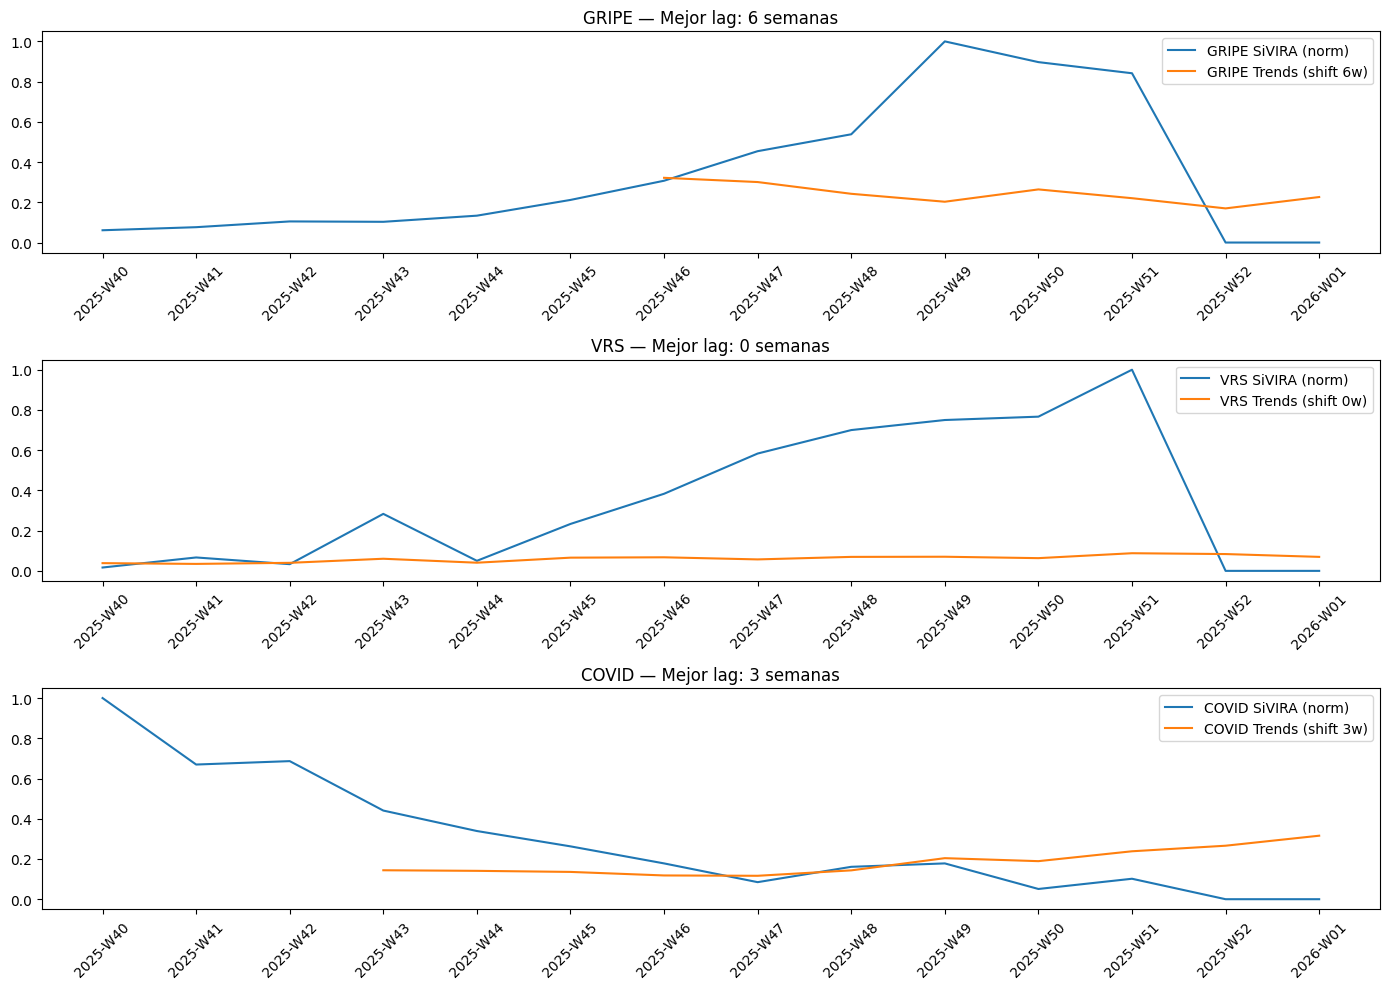

✅ Figura guardada: fig_overlay_all.png


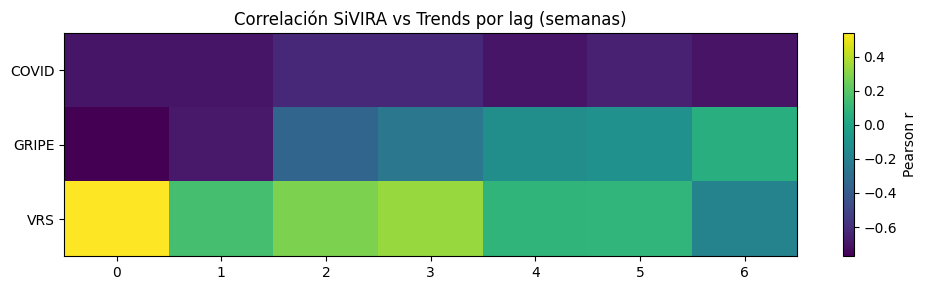

✅ Figura guardada: fig_lags_heatmap.png


lag_weeks,0,1,2,3,4,5,6
patologia,,,,,,,
COVID,-0.697389,-0.696596,-0.627196,-0.624574,-0.699073,-0.649813,-0.700437
GRIPE,-0.770975,-0.680031,-0.344525,-0.252242,-0.124778,-0.106208,0.056486
VRS,0.538946,0.151142,0.280347,0.337852,0.084719,0.090958,-0.184584


In [4]:
# =========================
# CELDA 4 — FIGURAS
# =========================
df_w = pd.read_csv(OUT_WEEKLY_MERGED)
df_best = pd.read_csv(OUT_LAGS_BEST)
df_lags = pd.read_csv(OUT_LAGS_ALL)

# Crear un eje temporal simple "year-week" para plot
df_w["yearweek"] = df_w["year"].astype(int).astype(str) + "-W" + df_w["week"].astype(int).astype(str).str.zfill(2)

# Normalizamos SiVIRA para overlay (0-1) para que se vea en el mismo gráfico que trends
def add_norm(df, col, new_col):
    df[new_col] = normalize_0_1(df[col].astype(float))
    return df

df_w = add_norm(df_w, "flu_pos_total",   "flu_norm")
df_w = add_norm(df_w, "rsv_pos_total",   "rsv_norm")
df_w = add_norm(df_w, "covid_pos_total", "covid_norm")

# Plot overlay por patología
overlay_specs = [
    ("GRIPE", "flu_norm",   "GRIPE_index"),
    ("VRS",   "rsv_norm",   "VRS_index"),
    ("COVID", "covid_norm", "COVID_index"),
]

plt.figure(figsize=(14,10))
for i, (pat, y_norm, x_idx) in enumerate(overlay_specs, start=1):
    lag = df_best.loc[df_best["patologia"]==pat, "best_lag_weeks"].iloc[0]
    lag = int(lag) if pd.notna(lag) else 0

    tmp = df_w.copy()
    tmp[f"{x_idx}_shifted"] = tmp[x_idx].shift(lag)

    plt.subplot(3,1,i)
    plt.plot(tmp["yearweek"], tmp[y_norm], label=f"{pat} SiVIRA (norm)")
    plt.plot(tmp["yearweek"], tmp[f"{x_idx}_shifted"], label=f"{pat} Trends (shift {lag}w)")
    plt.title(f"{pat} — Mejor lag: {lag} semanas")
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.savefig(OUT_FIG_OVERLAY, dpi=200)
plt.show()
print("✅ Figura guardada:", OUT_FIG_OVERLAY)

# Heatmap simple (sin seaborn)
# Pivot: patologia x lag -> r
pivot = df_lags.pivot_table(index="patologia", columns="lag_weeks", values="pearson_r", aggfunc="mean")

plt.figure(figsize=(10,3))
plt.imshow(pivot.values, aspect="auto")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.colorbar(label="Pearson r")
plt.title("Correlación SiVIRA vs Trends por lag (semanas)")
plt.tight_layout()
plt.savefig(OUT_FIG_LAGS, dpi=200)
plt.show()
print("✅ Figura guardada:", OUT_FIG_LAGS)

display(pivot)


In [5]:
# ============================================
# CELDA 4 — Merge SIVIRA + 3 Google Trends diarios
#          → semanal ISO → lags → figuras
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- 0) RUTAS ----------
BASE = "/content/"

SIVIRA_XLSX = f"{BASE}/tablas_informe_SiVIRA_202551.xlsx"

GT_GRIPE  = f"{BASE}/gt_index_daily_GRIPE.csv"
GT_VRS    = f"{BASE}/gt_index_daily_VRS.csv"
GT_COVID  = f"{BASE}/gt_index_daily_COVID.csv"

OUT_DIR = Path(f"{BASE}/out_figs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) CARGAR SIVIRA ----------
SIVIRA_SHEET = "detecciones_virales_iras_total_"

df_siv = pd.read_excel(SIVIRA_XLSX, sheet_name=SIVIRA_SHEET)
df_siv = df_siv.rename(columns={"ano": "year", "semana": "week"})

flu_cols = [c for c in df_siv.columns if c.lower() in ["anh1n1","ah3n2","ans","b","c"]]

df_sivira = df_siv[["year","week"] + flu_cols + ["sarscov2","vrs"]].copy()
df_sivira["flu_pos_total"]   = df_sivira[flu_cols].sum(axis=1)
df_sivira["covid_pos_total"] = df_sivira["sarscov2"]
df_sivira["rsv_pos_total"]   = df_sivira["vrs"]

df_sivira = df_sivira[["year","week","flu_pos_total","covid_pos_total","rsv_pos_total"]]
df_sivira = df_sivira.sort_values(["year","week"]).reset_index(drop=True)

print("✅ SIVIRA weekly")
display(df_sivira.head())

# ---------- 2) FUNCIONES GT ----------
def load_gt_daily(path, index_col):
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    return df[["date", index_col]]

def daily_to_weekly(df, value_col):
    iso = df["date"].dt.isocalendar()
    df["year"] = iso.year.astype(int)
    df["week"] = iso.week.astype(int)
    return (
        df.groupby(["year","week"], as_index=False)[value_col]
          .mean()
          .sort_values(["year","week"])
          .reset_index(drop=True)
    )

# ---------- 3) CARGAR Y CONVERTIR GOOGLE TRENDS ----------
gt_gripe  = daily_to_weekly(load_gt_daily(GT_GRIPE,  "GRIPE_index"), "GRIPE_index")
gt_vrs    = daily_to_weekly(load_gt_daily(GT_VRS,    "VRS_index"),   "VRS_index")
gt_covid  = daily_to_weekly(load_gt_daily(GT_COVID,  "COVID_index"), "COVID_index")

# Merge GT
gt_weekly = (
    gt_gripe
      .merge(gt_vrs,   on=["year","week"], how="outer")
      .merge(gt_covid, on=["year","week"], how="outer")
      .sort_values(["year","week"])
      .reset_index(drop=True)
)

print("✅ Google Trends weekly")
display(gt_weekly.head())

# ---------- 4) MERGE SIVIRA + GT ----------
df = df_sivira.merge(gt_weekly, on=["year","week"], how="inner")

print("✅ Dataset final merged")
display(df.head())

# ---------- 5) ANALISIS DE LAGS ----------
def best_lead(df, y, x, max_lead=6):
    res = []
    for k in range(max_lead + 1):
        r = df[y].corr(df[x].shift(k))
        res.append((k, r))
    out = pd.DataFrame(res, columns=["lead_weeks","pearson_r"])
    return out.sort_values("pearson_r", ascending=False)

results = []

targets = {
    "GRIPE": ("flu_pos_total","GRIPE_index"),
    "VRS":   ("rsv_pos_total","VRS_index"),
    "COVID": ("covid_pos_total","COVID_index")
}

for pat,(y,x) in targets.items():
    tab = best_lead(df, y, x)
    tab.to_csv(OUT_DIR/f"lag_table_{pat}.csv", index=False)
    best = tab.iloc[0]
    results.append({
        "patologia": pat,
        "best_lead_weeks": int(best.lead_weeks),
        "best_r": float(best.pearson_r)
    })
    print(f"\n{pat}")
    display(tab.sort_values("lead_weeks"))

df_best = pd.DataFrame(results)
df_best.to_csv(OUT_DIR/"lag_analysis_best.csv", index=False)

print("\n✅ Best lags")
display(df_best)

# ---------- 6) FIGURAS OVERLAY ----------
def z(s): return (s - s.mean()) / s.std()

for pat,(y,x) in targets.items():
    lead = int(df_best[df_best.patologia==pat].best_lead_weeks.iloc[0])
    tmp = df.copy()
    tmp["gt"] = tmp[x].shift(lead)

    plt.figure(figsize=(12,4))
    plt.plot(z(tmp[y]), label="SIVIRA")
    plt.plot(z(tmp["gt"]), label=f"GT (lead {lead}w)")
    plt.title(f"{pat} — Overlay GT vs SIVIRA")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR/f"overlay_{pat}.png", dpi=200)
    plt.close()

print("\n✅ Figuras guardadas en", OUT_DIR)



✅ SIVIRA weekly


,year,week,flu_pos_total,covid_pos_total,rsv_pos_total
0,2025,40,32,118,1
1,2025,41,40,79,4
2,2025,42,55,81,2
3,2025,43,54,52,17
4,2025,44,70,40,3


✅ Google Trends weekly


,year,week,GRIPE_index,VRS_index,COVID_index
0,2025,40,0.321763,0.038400,0.143891
1,2025,41,0.300719,0.034632,0.141007
2,2025,42,0.242328,0.039988,0.135681
3,2025,43,0.202878,0.060279,0.118083
4,2025,44,0.264123,0.040594,0.116430


✅ Dataset final merged


,year,week,flu_pos_total,covid_pos_total,rsv_pos_total,GRIPE_index,VRS_index,COVID_index
0,2025,40,32,118,1,0.321763,0.038400,0.143891
1,2025,41,40,79,4,0.300719,0.034632,0.141007
2,2025,42,55,81,2,0.242328,0.039988,0.135681
3,2025,43,54,52,17,0.202878,0.060279,0.118083
4,2025,44,70,40,3,0.264123,0.040594,0.116430



GRIPE


,lead_weeks,pearson_r
0,0,-0.770975
1,1,-0.680031
2,2,-0.344525
3,3,-0.252242
4,4,-0.124778
5,5,-0.106208
6,6,0.056486



VRS


,lead_weeks,pearson_r
0,0,0.538946
1,1,0.151142
2,2,0.280347
3,3,0.337852
4,4,0.084719
5,5,0.090958
6,6,-0.184584



COVID


,lead_weeks,pearson_r
0,0,-0.697389
1,1,-0.696596
2,2,-0.627196
3,3,-0.624574
4,4,-0.699073
5,5,-0.649813
6,6,-0.700437



✅ Best lags


,patologia,best_lead_weeks,best_r
0,GRIPE,6,0.056486
1,VRS,0,0.538946
2,COVID,3,-0.624574



✅ Figuras guardadas en /content/out_figs


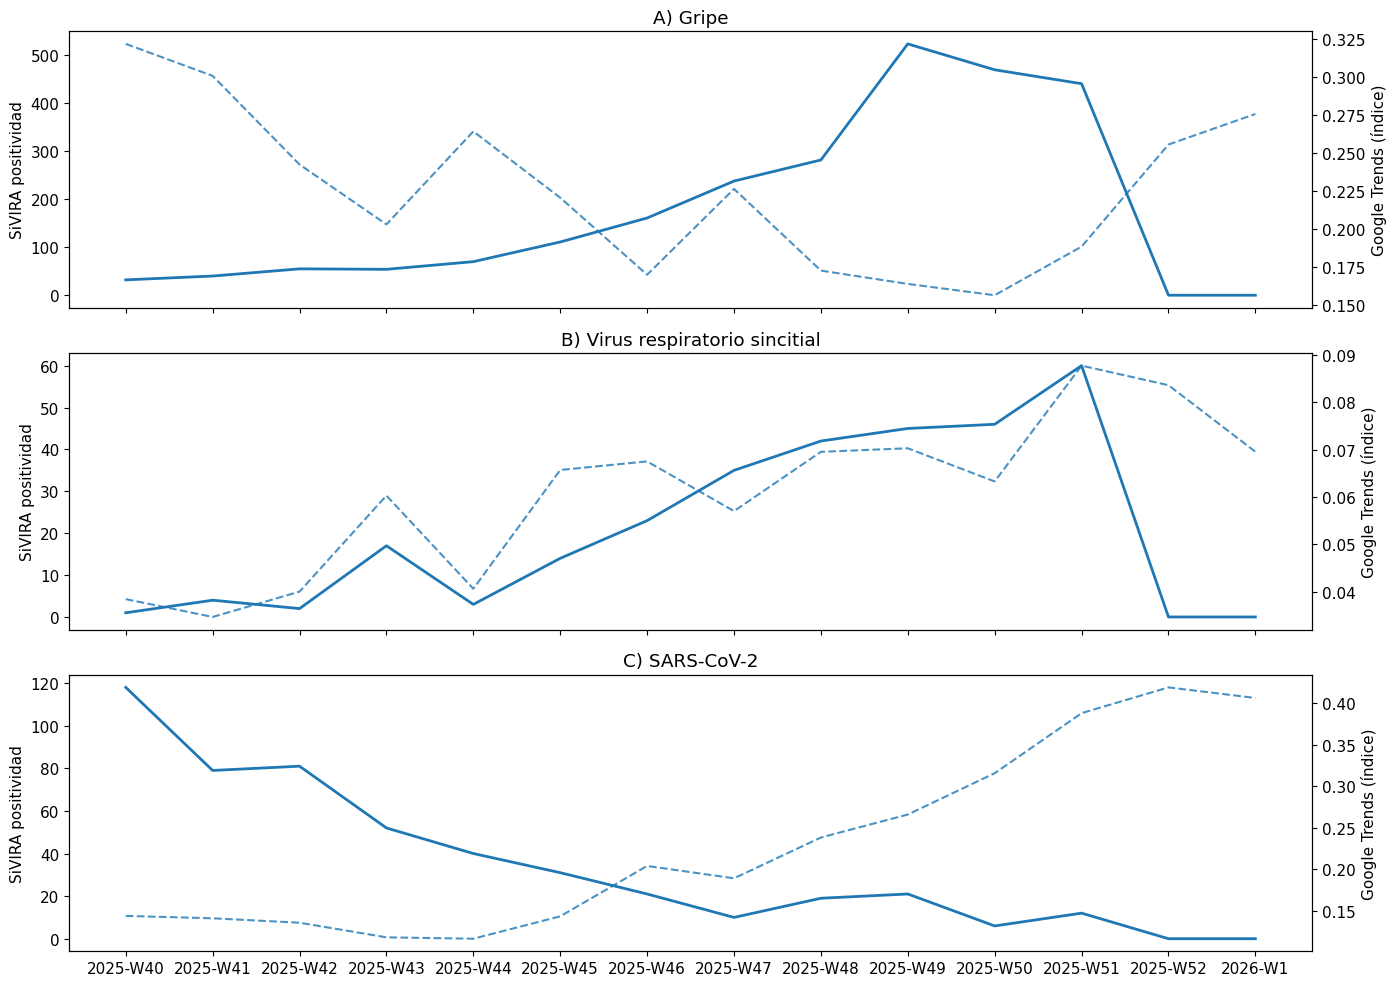

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset final
df = pd.read_csv("merged_sivira_trends_weekly.csv")

# Crear variable temporal (año-semana)
df["time"] = df["year"].astype(str) + "-W" + df["week"].astype(str)

# Configuración general
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 11

fig, axes = plt.subplots(3, 1, sharex=True)

# ---------- A) GRIPE ----------
ax = axes[0]
ax.plot(df["time"], df["flu_pos_total"], label="SiVIRA – Gripe", linewidth=2)
ax.set_ylabel("SiVIRA positividad")
ax.set_title("A) Gripe")

ax2 = ax.twinx()
ax2.plot(df["time"], df["GRIPE_index"], linestyle="--", label="Google Trends", alpha=0.8)
ax2.set_ylabel("Google Trends (índice)")

# ---------- B) VRS ----------
ax = axes[1]
ax.plot(df["time"], df["rsv_pos_total"], label="SiVIRA – VRS", linewidth=2)
ax.set_ylabel("SiVIRA positividad")
ax.set_title("B) Virus respiratorio sincitial")

ax2 = ax.twinx()
ax2.plot(df["time"], df["VRS_index"], linestyle="--", label="Google Trends", alpha=0.8)
ax2.set_ylabel("Google Trends (índice)")

# ---------- C) COVID ----------
ax = axes[2]
ax.plot(df["time"], df["covid_pos_total"], label="SiVIRA – COVID-19", linewidth=2)
ax.set_ylabel("SiVIRA positividad")
ax.set_title("C) SARS-CoV-2")

ax2 = ax.twinx()
ax2.plot(df["time"], df["COVID_index"], linestyle="--", label="Google Trends", alpha=0.8)
ax2.set_ylabel("Google Trends (índice)")

# Ajustes finales
plt.xticks(rotation=45)
plt.xlabel("Semana epidemiológica")

plt.tight_layout()
plt.savefig("figura_1_curvas_superpuestas.png", dpi=300)
plt.show()
